# Proyecto

Imports

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

Variables de entorno

In [35]:

max_carros = 20 
lambda_ns = 0.2  # Tasa de llegada para Norte-Sur
lambda_eo = 0.1  # Tasa de llegada para Este-Oeste
acciones = [0, 1]  # Mantener y cambiar


Espacio de estados

In [36]:
# Generamos todos los estados posibles
estados = []
for n in range(max_carros + 1):
    for m in range(max_carros + 1):
        for s in [0, 1]:
            estados.append((n, m, s))


Q-table

In [37]:
# Inicializar la tabla Q con ceros
Q_table = {}
for estado in estados:
    Q_table[estado] = np.zeros(len(acciones))


### Algortimo

Parametros de aprendizaje

In [38]:

alpha = 0.2 # Tasa de aprendizaje (entre 0.1 y 0.5) (valores altos -> rapido e insetable) (valores bajos -> lento y estable)
gamma = 0.95  # Factor de descuento (entre 0.9 y 0.99) (valores altos -> recompensas a futuro) (valores bajos -> recompensas cercanas)
epsilon_inicial = 1.0
epsilon_final = 0.01
simulaciones = 100000

decre_simulacion = int(simulaciones * 0.8) 
epsilon_decre = (epsilon_final / epsilon_inicial) ** (1 / decre_simulacion)


Funcion de transicion

In [39]:
def paso_discreto(estado, accion):
    n, m, s = estado
    recompensa = 0

    # Llegada de nuevos carros bajo Poisson
    nuevos_ns = np.random.poisson(lambda_ns)
    nuevos_eo = np.random.poisson(lambda_eo)

    n = min(n + nuevos_ns, max_carros)
    m = min(m + nuevos_eo, max_carros)

    # Si mantiene
    if accion == 0:
        if s == 0 and n > 0: # Si hay carros en NS
            n -= 1 # Pasa un auto
            recompensa += 1
        elif s == 1 and m > 0:# Si hay carros en EO
            m -= 1 # Pasa un auto
            recompensa += 1
    # Si cambia
    else:
        s = 1 - s  # Cambiar estado del semáforo
        recompensa -= 0.5  # penalizacion de cambio

        pass # Solo pasa 1 auto

    # Penalizacion autos en espera
    recompensa -= 0.1 * (n + m)

    # Estado actualizado
    sig_estado = (n, m, s)

    return sig_estado, recompensa


Bucle de entrenamiento

In [40]:
epsilon = epsilon_inicial

# Analisis de recompensas
recompensas_simulaciones = [] # recompensas por simulacion

# Analisis de convergencia
valores_delta_q = []
Q_table_anterior = None

# Analisis de politica
cambios_politica = []
politica_anterior = None

for simulacion in range(simulaciones):
    
    # Estado inicial aleatorio
    estado = (np.random.randint(0, max_carros + 1),
             np.random.randint(0, max_carros + 1),
             np.random.choice([0, 1]))

    terminar = False
    recompensa_total = 0
    pasos = 0

    while not terminar:
    
        if np.random.rand() < epsilon:
            accion = np.random.choice(acciones)
        else:
            accion = np.argmax(Q_table[estado]) 

        sig_estado, recompensa = paso_discreto(estado, accion)

        # Actualización de Q-learning
        sig_mejor_accion = np.argmax(Q_table[sig_estado])

        td_objetivo = recompensa + gamma * Q_table[sig_estado][sig_mejor_accion] # R + gamma * Q(St+1, a)
        td_error = td_objetivo - Q_table[estado][accion] # td_target - Q(S, A)

        Q_table[estado][accion] += alpha * td_error # Q(S, A) + alpha *  -> Actualiza probabilidad

        # Actualizar el estado
        estado = sig_estado
        pasos += 1

        # Condición para terminar el episodio
        if pasos >= 100:
            recompensa_total += recompensa
            terminar = True

    # Decaimiento de epsilon
    if epsilon > epsilon_final:
        epsilon *= epsilon_decre
    else:
        epsilon = epsilon_final

    # Analisis de Recompensas
    recompensas_simulaciones.append(recompensa_total)

    # Analsiis de Convergencia
    if Q_table_anterior is not None:
        delta_Q = 0
        for estado in Q_table:
            delta_Q += np.sum(np.abs(Q_table[estado] - Q_table_anterior[estado]))
        valores_delta_q.append(delta_Q / len(acciones)*len(estados))

        # Analisis de Politica
        cambios = sum(np.argmax(Q_table[estado]) != np.argmax(Q_table_anterior[estado]) for estado in Q_table)
        cambios_politica.append(cambios / len(estados))

    Q_table_anterior = deepcopy(Q_table)

    # Mostrar progreso cada 100 simulaciones
    if (simulacion + 1) % (simulaciones // 10) == 0:
        print(f'Episodio {simulacion + 1}/{simulaciones}, epsilon: {epsilon:.4f}')


Episodio 10000/100000, epsilon: 0.5623
Episodio 20000/100000, epsilon: 0.3162
Episodio 30000/100000, epsilon: 0.1778
Episodio 40000/100000, epsilon: 0.1000
Episodio 50000/100000, epsilon: 0.0562
Episodio 60000/100000, epsilon: 0.0316
Episodio 70000/100000, epsilon: 0.0178
Episodio 80000/100000, epsilon: 0.0100
Episodio 90000/100000, epsilon: 0.0100
Episodio 100000/100000, epsilon: 0.0100


### Evaluar rendimiento

En este punto tenemos una Q-table ya entrenada y lista para usarse en diferentes evaluaciones. Veamos que recompensa obtiene en algunas de ellas:

In [41]:
for i in range(10):
    estado = (np.random.randint(0, max_carros + 1),
            np.random.randint(0, max_carros + 1),
            np.random.choice([0, 1]))
    recompensa_total = 0
    pasos = 0
    max_pasos = 10**((i%3)+1)

    while pasos < max_pasos:
        accion = np.argmax(Q_table[estado])  # Seleccionar la mejor acción
        sig_estado, recompensa = paso_discreto(estado, accion)
        recompensa_total += recompensa
        estado = sig_estado
        pasos += 1

    print(f'Evaluacion: {i}\t Pasos: {max_pasos}:\t Recompensa total: {recompensa_total}')


Evaluacion: 0	 Pasos: 10:	 Recompensa total: 2.5999999999999996
Evaluacion: 1	 Pasos: 100:	 Recompensa total: 7.099999999999999
Evaluacion: 2	 Pasos: 1000:	 Recompensa total: 164.70000000000067
Evaluacion: 3	 Pasos: 10:	 Recompensa total: -1.0000000000000004
Evaluacion: 4	 Pasos: 100:	 Recompensa total: 10.500000000000002
Evaluacion: 5	 Pasos: 1000:	 Recompensa total: 141.60000000000022
Evaluacion: 6	 Pasos: 10:	 Recompensa total: -12.500000000000004
Evaluacion: 7	 Pasos: 100:	 Recompensa total: -14.100000000000012
Evaluacion: 8	 Pasos: 1000:	 Recompensa total: 175.90000000000066
Evaluacion: 9	 Pasos: 10:	 Recompensa total: 4.7


Note que al definir $\alpha = 0.2$ como un valor pequeño, nuestro agente va a priorizar la obtencion de recompensas a largo plazo, por esto, en la evaluaciones donde solo ocurrieron 10 pasos la recompensa fue negativa. La politica que el agente conoce esta pensada a futuro y por esto en las evaluaciones con mas pasos se puede ver como la recompensa aumenta bastante si se le da mas tiempo.

#### Cambio en Recompensas:

Veamos como evoluciono el calculo de recompensas durante la ejecucion del algoritmo:

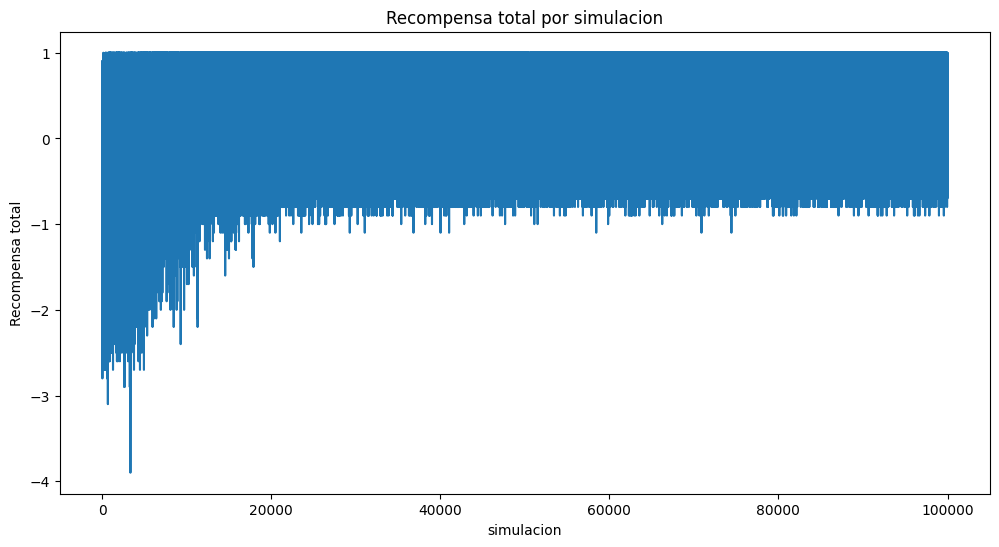

In [42]:

plt.figure(figsize=(12, 6))
plt.plot(recompensas_simulaciones)
plt.xlabel('simulacion')
plt.ylabel('Recompensa total')
plt.title('Recompensa total por simulacion')


#valor_minimo = np.percentile(recompensas_simulaciones, 5)
# = np.percentile(recompensas_simulaciones, 95)


plt.show()

Como se puede observar, las recompensas suelen estar entre 1 y -1. Para nuestras recompensas en cada paso de tiempo discreto pasa un auto y por esto se le da una recompensa de 1 al agente, pero al mismo tiempo por cada auto en espera se penaliza con 0.1 y con 0.5 si cambia la via en verde. Esto causa que el agente priorice estar en estados donde la penalizacion por la cantidad de carros en espera no supere la recompensa positiva que gana en cada cambio de estado.

#### Recompensa promedio:

Ahora nos interesa observar como se ve la ganancia de recompensas con el pasar del tiempo. Esto lo conseguimos con promedio movil de la forma:

$$ PM_{t} = \frac{1}{k} \sum_{i=t-k+1} x_{i}$$

Donde:

- $x_{i}$ es el valor de la recompensa en la simulacion $i$
- $t$ es la simulacion actual
- $k$ es el numero de datos a promediar, donde $k \geq t$

Este $k$ se conoce como tamaño de la ventana del promedio movil, y en nuestro caso lo tomamos como el 5% de las simualciones para tener un buen suavizado en los datos y no perder valores importantes

Ahora veamos como se ve este promedio para cada simulacion:

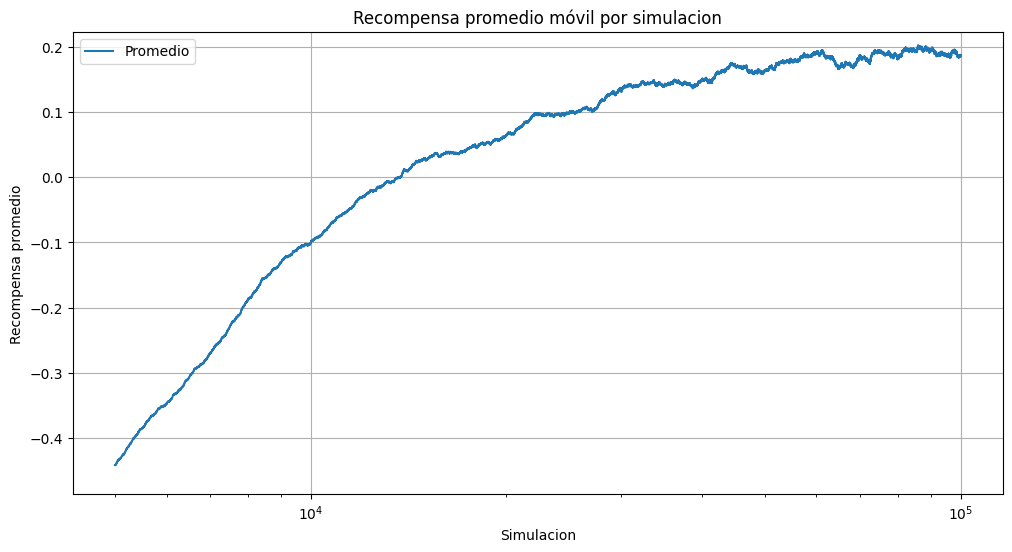

In [43]:
import numpy as np
import matplotlib.pyplot as plt

size = int(simulaciones*0.05)
moving_avg = np.convolve(recompensas_simulaciones, np.ones(size)/size, mode='valid')

plt.figure(figsize=(12, 6))

plt.plot(range(size, len(recompensas_simulaciones)+1), moving_avg, label='Promedio')

plt.ylim([np.min(moving_avg)*1.1, np.max(moving_avg)*1.1]) 

plt.xlabel('Simulacion')
plt.ylabel('Recompensa promedio')
plt.title('Recompensa promedio móvil por simulacion')

plt.xscale('log')


# Agregar cuadrícula
plt.grid(True)

# Mostrar leyenda si hay varias curvas
plt.legend()

# Mostrar el gráfico
plt.show()


#### Cambio en valores de Q:

Definimos el cambio en los valores de Q como:

$$ \Delta Q = \frac{1}{|S| \times |A|} \sum_{s\in S} \sum_{a\in A} |Q_{t+1}(s,a) - Q_{t}(s,a)|

Donde:

- $|S|$ es el espacio de estados
- $|A|$ es el espacio de acciones
- $Q_{t}(s,a)$ es el valor de $Q$ dados $s$ y $a$ en la simulacion $t$

Ahora veamos este cambio graficamente atravez de las simulaciones:

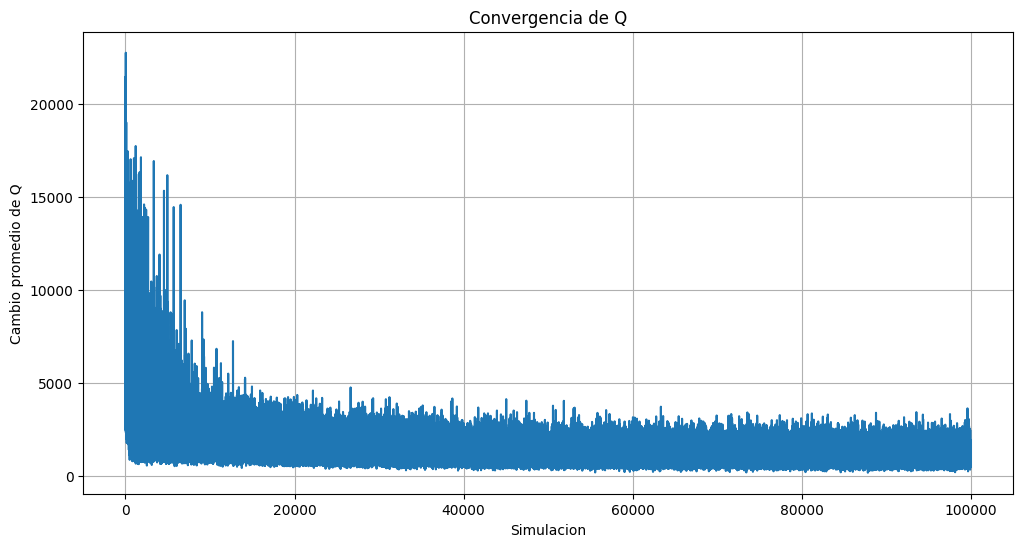

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(valores_delta_q)
plt.xlabel('Simulacion')
plt.ylabel('Cambio promedio de Q')
plt.title('Convergencia de Q')
#plt.xscale('log')
#plt.yscale('linear')
plt.grid(True)
plt.show()

Vemos como la diferencia entre valores de $Q$ decrece con el paso de las simulaciones, esto quiere decir que se acerca cada vez mas a una politica optima mediante el ajuste de valores en cada simulacion.

#### Cambios en politica:

Defininimos el cambio en la politica como:

$$ \Delta \delta = \sum_{s \in S} \frac{\delta (a_{t}(s), a_{t-1}(s))}{|S|} $$

Donde:

- $|S|$ es el espacio de estados
- $a_{t}(s)$ es la accion optima a tomar en el estado $s$ en la simulacion $t$
- $\delta(x_{1}, x_{2})$ es una funcion que vale 1 si la accion optima en el estado $s$ ha cambiado entre la simulacion $t$ y $t-1$, y 0 en otro caso.

Ahora veamos este cambio graficamente atravez de las simulaciones:

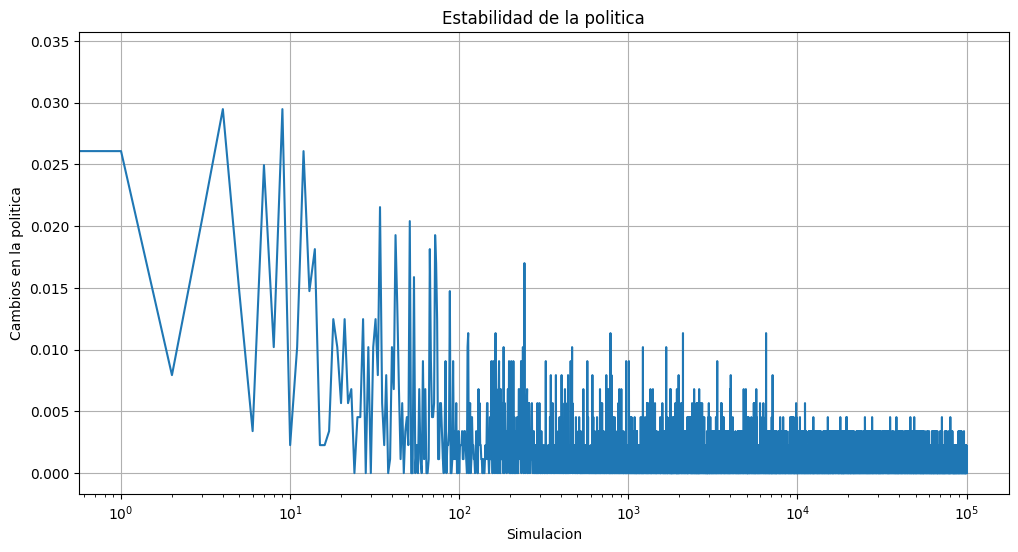

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(cambios_politica)
plt.xlabel('Simulacion')
plt.ylabel('Cambios en la politica')
plt.title('Estabilidad de la politica')
plt.xscale('log')
plt.grid(True)
plt.show()

Esta grafica nos da a entender que los cambios en la politica tienden a estabilizarse y ser cada vez mas pequeños a medida que avanza el algoritmo, esto nos interesa pues significa que esta hallando una politica que minimiza el tiempo de espera de los autos.

In [46]:
from pprint import pprint

pprint(Q_table)

{(0, 0, 0): array([3.96595187, 3.01615646]),
 (0, 0, 1): array([3.79802824, 2.8791113 ]),
 (0, 1, 0): array([3.37915017, 3.86849384]),
 (0, 1, 1): array([4.45340191, 3.06094517]),
 (0, 2, 0): array([3.79275413, 4.33954901]),
 (0, 2, 1): array([5.2444589 , 3.64124137]),
 (0, 3, 0): array([4.36253263, 4.8139622 ]),
 (0, 3, 1): array([5.83874338, 3.78423955]),
 (0, 4, 0): array([4.35806878, 5.09236144]),
 (0, 4, 1): array([6.32634254, 3.88335201]),
 (0, 5, 0): array([4.38620212, 5.18302194]),
 (0, 5, 1): array([6.63093713, 3.81813912]),
 (0, 6, 0): array([4.45433823, 5.15698115]),
 (0, 6, 1): array([6.66256292, 3.7182008 ]),
 (0, 7, 0): array([3.944415  , 5.01252682]),
 (0, 7, 1): array([6.65616933, 3.46587331]),
 (0, 8, 0): array([3.98395377, 4.6190607 ]),
 (0, 8, 1): array([6.49054329, 3.11677621]),
 (0, 9, 0): array([3.30364928, 4.49077096]),
 (0, 9, 1): array([6.29058296, 2.58716468]),
 (0, 10, 0): array([2.66009468, 3.87283266]),
 (0, 10, 1): array([5.73873346, 2.10004896]),
 (0, 11,